The purpose of this notebook is to create a GIF using a choropleth map of the US that shows the total number of influenza infections reported in the Influenza Research Database during the 2017-2018 season. 

Each map will show the total number of infections per month, moving from October to May, since those are the months that had cases, according to my figure in the general influenza data study.

The goal is to get a template that can applied to any type of outbreak.



In [15]:
# load required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import calendar
import os
import time

# allow plots to present within notebook
%matplotlib inline

In [16]:
ls

GIF.ipynb              charts/                states_21basic/
Influenza-GIF/         fluA_strains.tsv*      tl_2018_us_state/
cb_2017_us_state_500k/ fluB_strains.tsv*


In [17]:
# load shapefile

fp = "states_21basic/states.shp"
usmap_df = gpd.read_file(fp)
usmap_df = usmap_df[~usmap_df.STATE_NAME.isin(['Alaska', 'Hawaii'])]
usmap_df.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...
5,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...


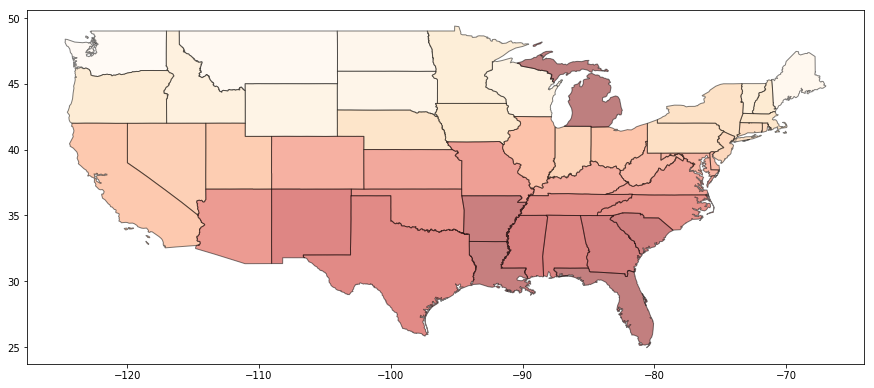

In [18]:
# view shapefile and its data
# for simplicity will omit Alaska and Hawaii


plot = usmap_df.plot(cmap='OrRd', figsize=(15,15),alpha=0.5, edgecolor='k' )
    
            

In [19]:
# import influenza csv 

fluA_df = pd.read_csv('fluA_strains.tsv', sep='\t')
fluB_df = pd.read_csv('fluB_strains.tsv', sep='\t')

fluA_df.head(3)

,Strain Name,Complete Genome,Subtype,Collection Date,Host,Country,State/Province,Geographic Grouping,Flu Season,Submission Date,...,RERRRKKR,Sensitive Drug,Resistant Drug,Submission Date.1,NCBI Taxon ID,pH1N1-like,US Swine H1 Clade,Global Swine H1 Clade test,H5 Clade,Unnamed: 52
0,A/Alabama/01/2018,Yes,H1N1,01/02/2018,Human,USA,Alabama,North America,17-18,2018-03-24,...,No,-N/A-,-N/A-,03/24/2018,11320,Mixed Positive and Negative Segments,npdm,1A.3.3.2,-N/A-,NaN
1,A/Alabama/02/2018,Yes,H1N1,01/03/2018,Human,USA,Alabama,North America,17-18,2018-03-24,...,No,"Oseltamivir,Zanamivir",-N/A-,03/24/2018,11320,Mixed Positive and Negative Segments,npdm,1A.3.3.2,-N/A-,NaN
2,A/Alabama/03/2018,Yes,H3N2,01/03/2018,Human,USA,Alabama,North America,17-18,2018-03-24,...,No,-N/A-,-N/A-,03/24/2018,11320,Negative,-N/A-,-N/A-,-N/A-,NaN


In [20]:
# merge both fluA+fluB DataFrames into one

fluAB_df = pd.merge(fluA_df, fluB_df, how = 'outer')

fluAB_df.sample(5)

,Strain Name,Complete Genome,Subtype,Collection Date,Host,Country,State/Province,Geographic Grouping,Flu Season,Submission Date,...,Resistant Drug,Submission Date.1,NCBI Taxon ID,pH1N1-like,US Swine H1 Clade,Global Swine H1 Clade test,H5 Clade,Unnamed: 52,1 PB1,2 PB2
5781,B/Washington/44/2017,Yes,-N/A-,11/20/2017,Human,USA,Washington,North America,17-18,2018-01-02,...,-N/A-,01/02/2018,2067653,-N/A-,-N/A-,-N/A-,-N/A-,NaN,CY263482,CY263483
1956,A/Montana/24/2017,Yes,H3N2,10/17/2017,Human,USA,Montana,North America,17-18,2017-12-22,...,-N/A-,Inconsistent,2054985,Negative,-N/A-,-N/A-,-N/A-,NaN,NaN,NaN
4619,B/Florida/10/2018,No,-N/A-,01/25/2018,Human,USA,Florida,North America,17-18,2018-07-12,...,-N/A-,07/12/2018,11520,-N/A-,-N/A-,-N/A-,-N/A-,NaN,-N/A-,-N/A-
873,A/District Of Columbia/04/2018,Yes,H1N1,01/25/2018,Human,USA,District of Columbia,North America,17-18,2018-05-13,...,-N/A-,05/13/2018,11320,Mixed Positive and Negative Segments,npdm,1A.3.3.2,-N/A-,NaN,NaN,NaN
5506,B/Pennsylvania/13/2018,Yes,-N/A-,05/02/2018,Human,USA,Pennsylvania,North America,17-18,2018-07-17,...,-N/A-,07/17/2018,11520,-N/A-,-N/A-,-N/A-,-N/A-,NaN,MH606830,MH606829


In [21]:
# state abbreviations

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}


In [22]:
# makes a new column 'abbrev' that maps the State name to its abreviation from above cell.

fluAB_df['abbrev'] = fluAB_df['State/Province'].map(us_state_abbrev)

In [23]:
fluAB_df.sample(3)

,Strain Name,Complete Genome,Subtype,Collection Date,Host,Country,State/Province,Geographic Grouping,Flu Season,Submission Date,...,Submission Date.1,NCBI Taxon ID,pH1N1-like,US Swine H1 Clade,Global Swine H1 Clade test,H5 Clade,Unnamed: 52,1 PB1,2 PB2,abbrev
4327,B/California/50/2017,Yes,-N/A-,11/02/2017,Human,USA,California,North America,17-18,2017-12-05,...,12/05/2017,2058068,-N/A-,-N/A-,-N/A-,-N/A-,NaN,CY258889,CY258890,CA
5124,B/Montana/19/2017,Yes,-N/A-,11/05/2017,Human,USA,Montana,North America,17-18,2018-07-12,...,Inconsistent,11520,-N/A-,-N/A-,-N/A-,-N/A-,NaN,"MH581881,MH131029,CY262437","MH581879,MH131027,CY262438",MT
4886,B/Louisiana/01/2018,Yes,-N/A-,01/14/2018,Human,USA,Louisiana,North America,17-18,2018-07-12,...,07/12/2018,11520,-N/A-,-N/A-,-N/A-,-N/A-,NaN,MH583414,MH583413,LA


In [24]:
# convert collection date to datetime obj

fluAB_df['Collection Date'] = pd.to_datetime(fluAB_df['Collection Date'])

type(fluAB_df['Collection Date'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [25]:
# apply the lambda function to the 'collection date' column and retreive the month, into 
# a new column named "month"

fluAB_df['Month'] = fluAB_df['Collection Date'].apply(lambda time: time.month)

fluAB_df['Month'].sample(5)

5183     3
3742     1
4352    11
1369     1
3770    12
Name: Month, dtype: int64

In [26]:
# convert numeral month to letter names


fluAB_df['Month'] = fluAB_df['Month'].apply(lambda x: calendar.month_name[x])


In [27]:
fluAB_df['Month'].sample(3)

1905     January
654     November
4274    December
Name: Month, dtype: object

In [28]:
#goal is to get a dataframe that lists the number of infections per month for every state.
#do a groupby sort by state and then month, and get a count of that filter.
#make a series and inject it into a new dataframe.

fluAB_byMonth_series = fluAB_df.groupby(["State/Province","Month"]).size()
# converts all NaN to zeros


fluAB_byMonth_df = pd.DataFrame(fluAB_byMonth_series)
fluAB_byMonth_df = fluAB_byMonth_df.reset_index()

fluAB_byMonth_df.sample(3)

,State/Province,Month,0
12,Alaska,April,10
203,Montana,January,17
144,Louisiana,December,8


In [29]:
# pivot the table so the months are columns, and the rows are states
# method chain with .fillna to get rid of all the NaN's

fluAB_fin = fluAB_byMonth_df.pivot(index='State/Province', columns='Month', values=0).fillna(0)
fluAB_fin.head(5)

Month,April,December,February,January,March,May,November,October
State/Province,,,,,,,,
-N/A-,7.0,235.0,39.0,260.0,31.0,0.0,64.0,3.0
Alabama,0.0,10.0,24.0,20.0,0.0,0.0,7.0,4.0
Alaska,10.0,15.0,14.0,9.0,15.0,9.0,22.0,11.0
Arizona,6.0,23.0,13.0,29.0,20.0,6.0,14.0,9.0
Arkansas,0.0,13.0,4.0,11.0,2.0,0.0,9.0,10.0


In [30]:
#merge the dataframes

merged = usmap_df.set_index('STATE_NAME').join(fluAB_fin)
merged.head(3)

,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry,April,December,February,January,March,May,November,October
STATE_NAME,,,,,,,,,,,,,
Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...,14.0,17.0,11.0,25.0,19.0,2.0,11.0,8.0
Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...,9.0,13.0,16.0,17.0,17.0,0.0,16.0,13.0
Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...,13.0,5.0,15.0,12.0,14.0,0.0,1.0,0.0


In [39]:
# I'm a tidy nerd and want only the required columns and have them sorted chronologically.

merged = merged[['October', 'November', 'December', 'January', 
                 'February', 'March', 'April', 'May', 'geometry']]

merged1 = merged.rename(columns={'October':'October 2017', 'November':'November 2017', 'December':'December 2017', 
                                 'January':'January 2018', 'February':'February 2018', 'March':'March 2018', 
                                 'April':'April 2018', 'May':'May 2018'})

merged1.head(3)

,October 2017,November 2017,December 2017,January 2018,February 2018,March 2018,April 2018,May 2018,geometry
STATE_NAME,,,,,,,,,
Washington,8.0,11.0,17.0,25.0,11.0,19.0,14.0,2.0,(POLYGON ((-122.4020153103835 48.2252163723779...
Montana,13.0,16.0,13.0,17.0,16.0,17.0,9.0,0.0,POLYGON ((-111.4754253002074 44.70216236909688...
Maine,0.0,1.0,5.0,12.0,15.0,14.0,13.0,0.0,(POLYGON ((-69.77727626137293 44.0741483685119...


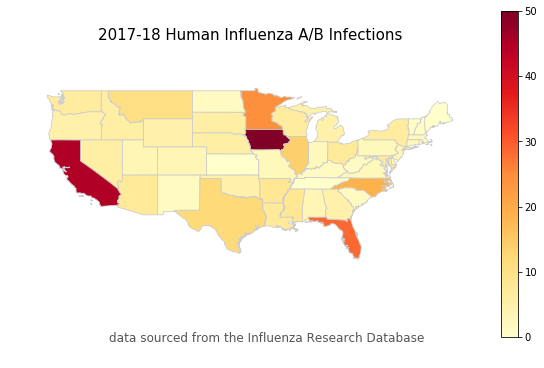

In [92]:
# going to test out one figure to see what it looks like

variable = 'October 2017'

vmin,vmax = 0,50

fig,ax = plt.subplots(1, figsize=(10,6))

merged1.plot(column=variable, cmap='YlOrRd', 
            figsize=(70,10), linewidth=0.8, ax=ax,
           edgecolor='0.8')

ax.axis('off')


title = ax.set_title('2017-18 Human Influenza A/B Infections', fontsize=15)
title.set_position([.5, 1.18])

ax.annotate('data sourced from the Influenza Research Database', xy=(0.2, 0.1),xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=12, color='#555555')

sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
 

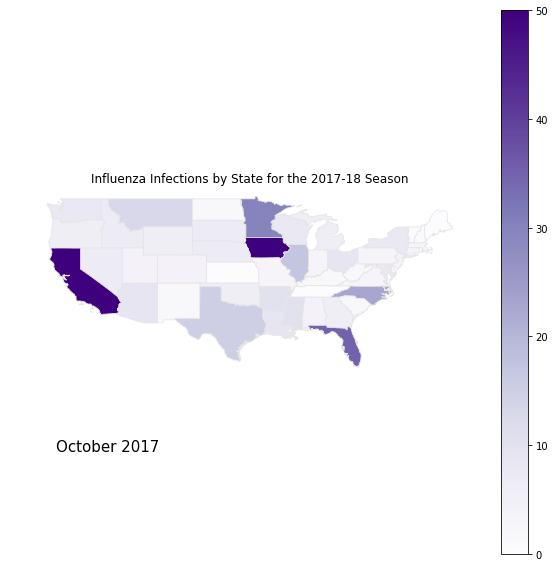

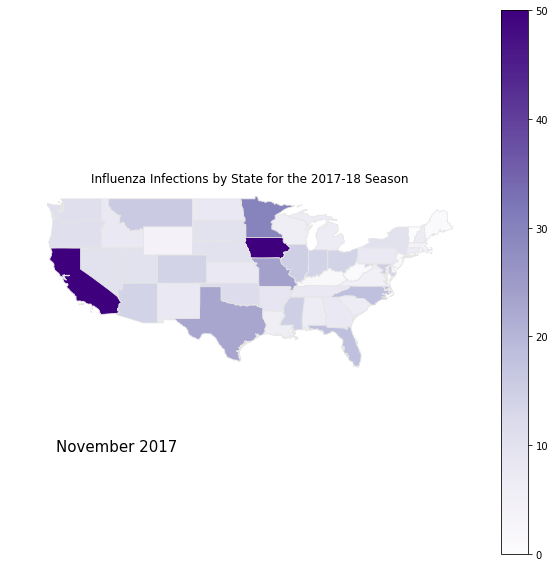

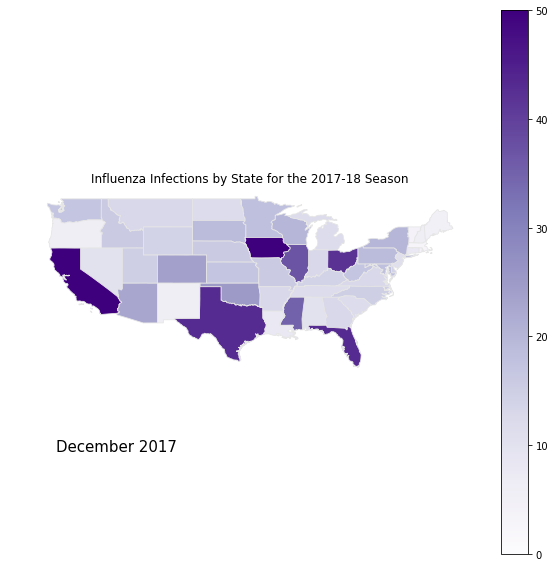

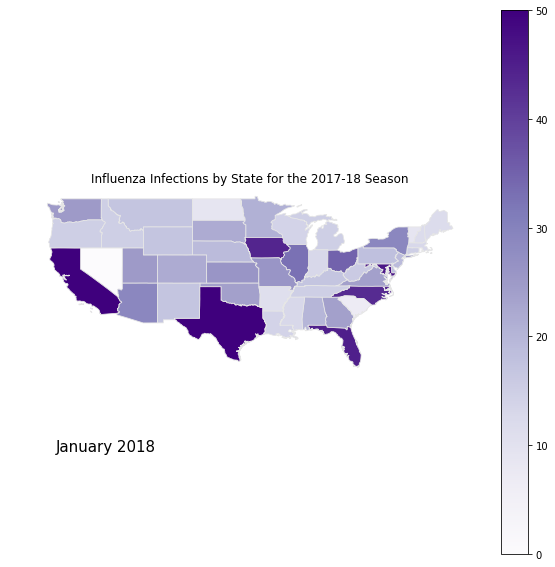

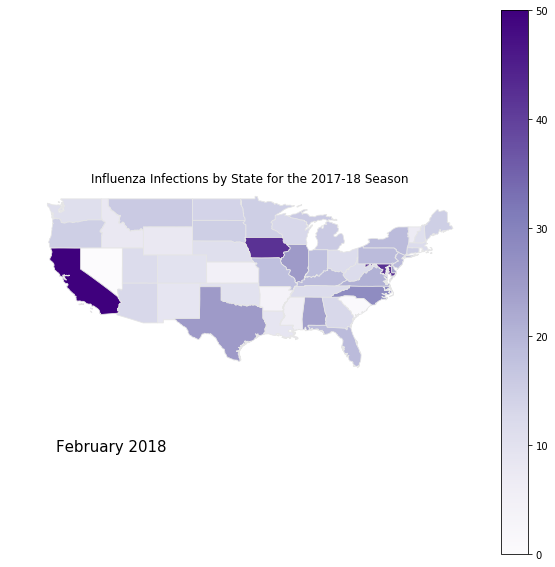

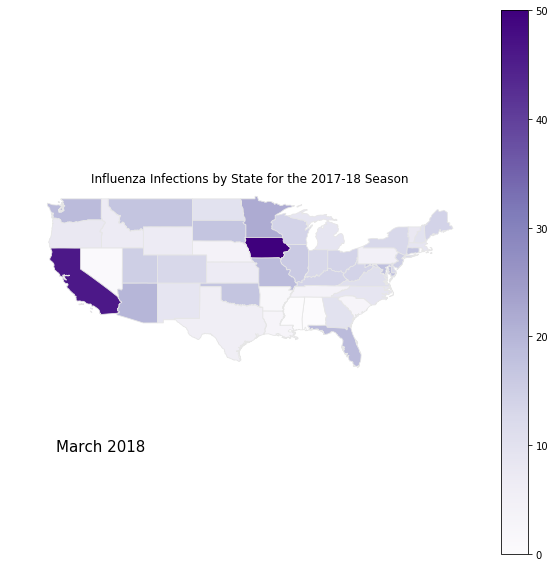

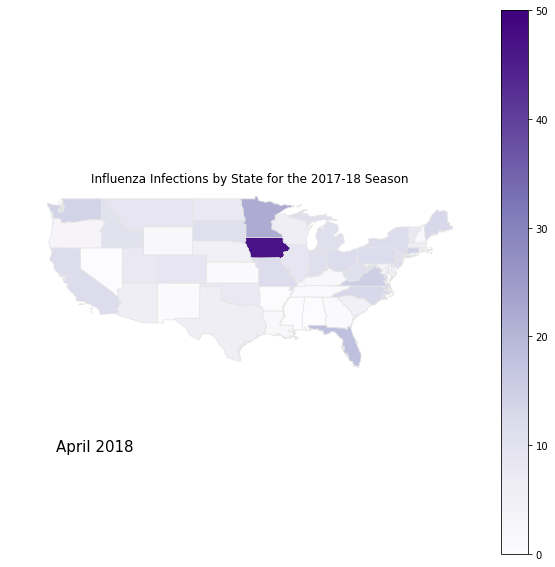

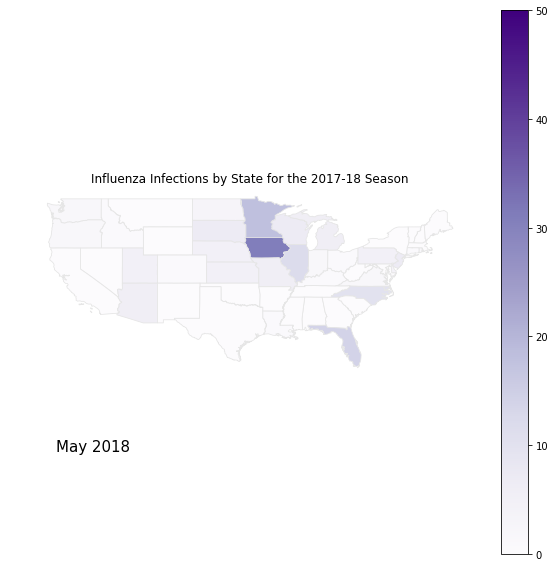

In [96]:
# Loop that creates multiple maps

# Where the maps will be saved
output_path = 'charts/maps'

# Counter
i = 0

# list of months
list_o_months = ['October 2017', 'November 2017', 'December 2017', 'January 2018', 'February 2018',
                'March 2018', 'April 2018', 'May 2018']

# colorbar min,max 
vmin, vmax = 0,50

# start the for loop to create a map per month
for month in list_o_months:
    fig = merged1.plot(column=month, cmap='Purples', figsize=(10,10), linewidth=0.8, 
                      edgecolor='0.9', vmin=vmin, vmax=vmax, legend=True,
                     norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    fig.axis('off')

    fig.set_title('Influenza Infections by State for the 2017-18 Season')

    fig.annotate(month, xy=(0.1, 0.225),xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=15)
    
    filepath = os.path.join(output_path, month+'_influenza.png')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)
